<a href="https://colab.research.google.com/github/mlartorg/visualML/blob/master/lucid_composite_content_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lucid

In [2]:
# Imports
from scipy import ndimage

%tensorflow_version 1.x
import numpy as np
import tensorflow as tf

from lucid.modelzoo import vision_models
from lucid.misc.io import show, load
from lucid.misc.tfutil import create_session
# from lucid.misc.ndimage_utils import resize

import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render

from lucid.optvis.objectives import wrap_objective

TensorFlow 1.x selected.


In [3]:
model = vision_models.InceptionV3_slim()
model.load_graphdef()

You can use this to see if you're running on a machine with a correctly configured GPU:

In [4]:
!nvidia-smi

Thu May 28 16:37:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Composite content transfer

Draw an image from noise that looks like both input images

In [0]:
def my_transfer_param(content_image1, content_image2, decorrelate=True, fft=True):
  transfer_input = param.image(*content_image1.shape[:2], decorrelate=decorrelate, fft=fft)[0]
  content_input1 = content_image1
  content_input2 = content_image2
  return tf.stack([transfer_input, content_input1, content_input2])

# these constants help remember which image is at which batch dimension
TRANSFER_INDEX = 0
CONTENT_INDEX1 = 1
CONTENT_INDEX2 = 2

(444, 790, 3)
(600, 900, 3)



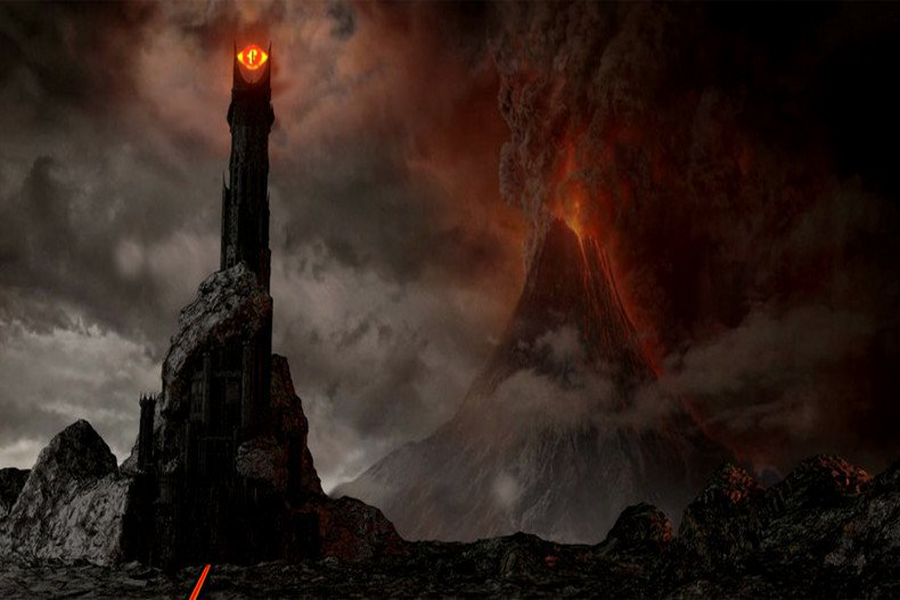


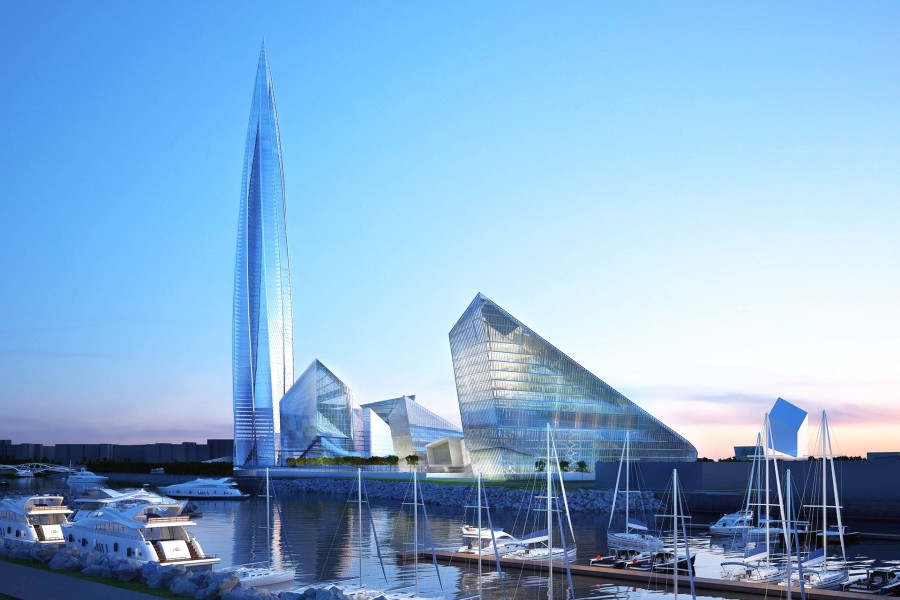

In [12]:
def resize(im, x, y=None):
  zfx = x / im.shape[0]
  zfy = y / im.shape[1] if y else zfx
  return ndimage.zoom(im, [zfx, zfy, 1])

# x, y = 256, 420
x, y = 600, 900
# x, y = 600 * 1.28, 900 * 1.28

content1 = load("https://pbs.twimg.com/media/DbHFjSBW0AAKEN-.jpg")
print(content1.shape)
content1 = resize(content1, x, y)

content2 = load("https://i.imgur.com/lh9I5Fn.jpg")
print(content2.shape)
content2 = resize(content2, x, y)

show(content1)
show(content2)

In [0]:
def mean_L1(a, b):
  return tf.reduce_mean(tf.abs(a-b))

@wrap_objective
def composite_obj(layer_names, activation_loss_f=mean_L1, transform_f=None):
  def inner(T):
    # first we collect the (constant) activations of image we're computing the difference to
    image_activations1 = [T(layer_name)[1] for layer_name in layer_names]
    image_activations2 = [T(layer_name)[2] for layer_name in layer_names]

    act_sum = [tf.add(a, b) for a, b in zip(image_activations1, image_activations2)]
    # act_max = [tf.math.maximum(a, b) for a, b in zip(image_activations1, image_activations2)]
    # print(act_sum)

    # we also set get the activations of the optimized image which will change during optimization
    optimization_activations = [T(layer)[0] for layer in layer_names]
    if transform_f is not None:
      optimization_activations = [transform_f(act) for act in optimization_activations]

    # we use the supplied loss function to compute the actual losses
    
    # losses = [activation_loss_f(a, b) for a, b in zip(image_activations1, optimization_activations)]
    # losses += [activation_loss_f(a, b) for a, b in zip(image_activations2, optimization_activations)]

    losses = [activation_loss_f(a, b) for a, b in zip(act_sum, optimization_activations)]
    # losses = [activation_loss_f(a, b) for a, b in zip(act_max, optimization_activations)]


    return tf.add_n(losses)

  return inner

In [15]:

content_layers = [
  l.name for l in model.layers[-12:-4]
]

for l in content_layers:
  print(l)

InceptionV3/InceptionV3/Mixed_5b/concat
InceptionV3/InceptionV3/Mixed_5c/concat
InceptionV3/InceptionV3/Mixed_5d/concat
InceptionV3/InceptionV3/Mixed_6a/concat
InceptionV3/InceptionV3/Mixed_6b/concat
InceptionV3/InceptionV3/Mixed_6c/concat
InceptionV3/InceptionV3/Mixed_6d/concat
InceptionV3/InceptionV3/Mixed_6e/concat


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



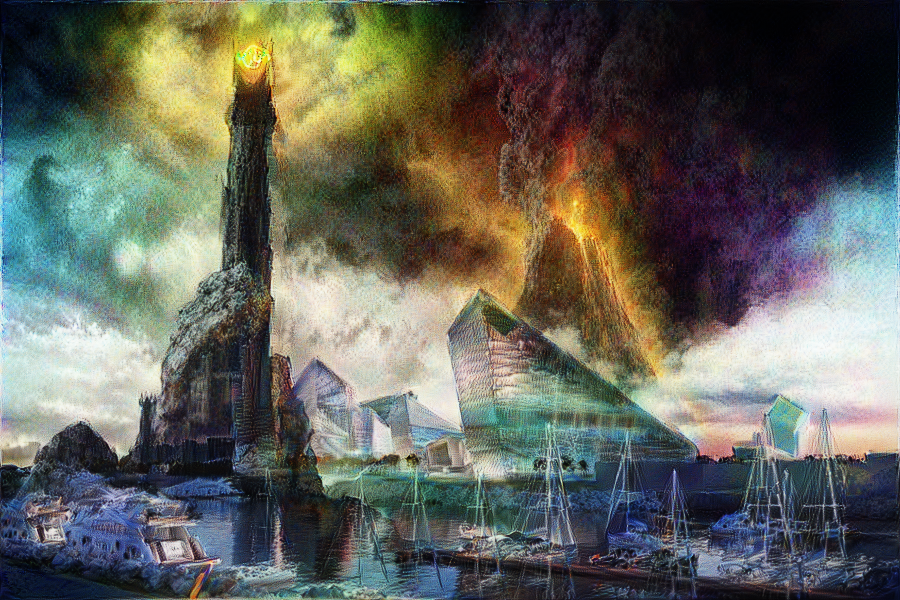
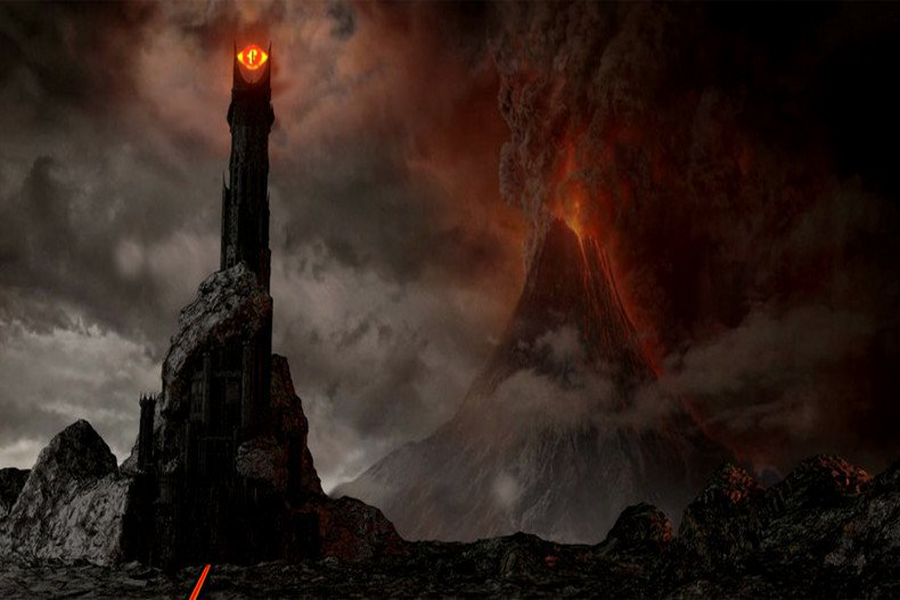
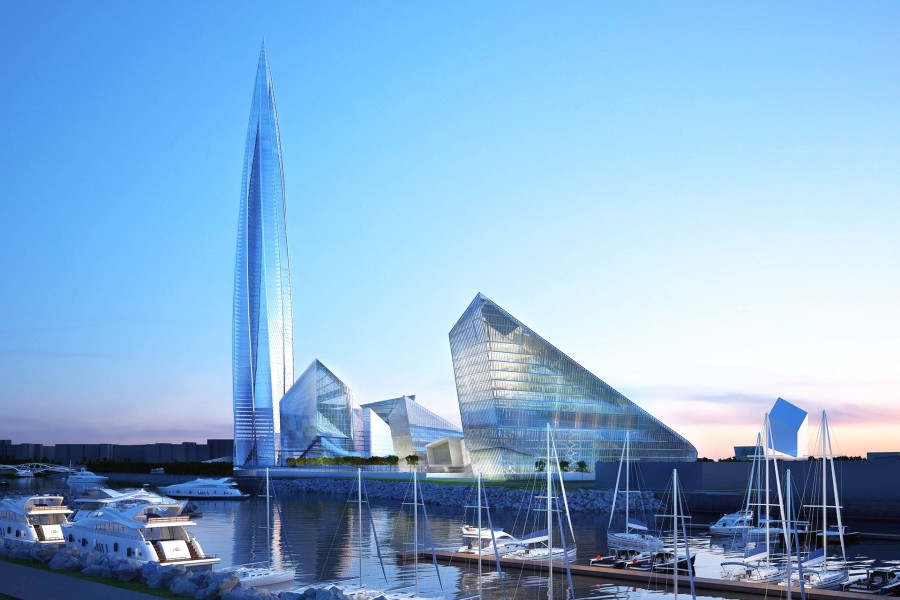

In [17]:
param_f = lambda: my_transfer_param(content1, content2) 

content_obj = composite_obj(content_layers)
content_obj.description = "Content Loss"

objective = - content_obj * 10 # + sum([objectives.deepdream(l.name) for l in model.layers[-3:-1]]) * 0.5

vis = render.render_vis(model, objective, param_f=param_f, thresholds=[256], verbose=False)[-1]
show(vis)

Neat!

# Compare to content transfer on direct sum of images


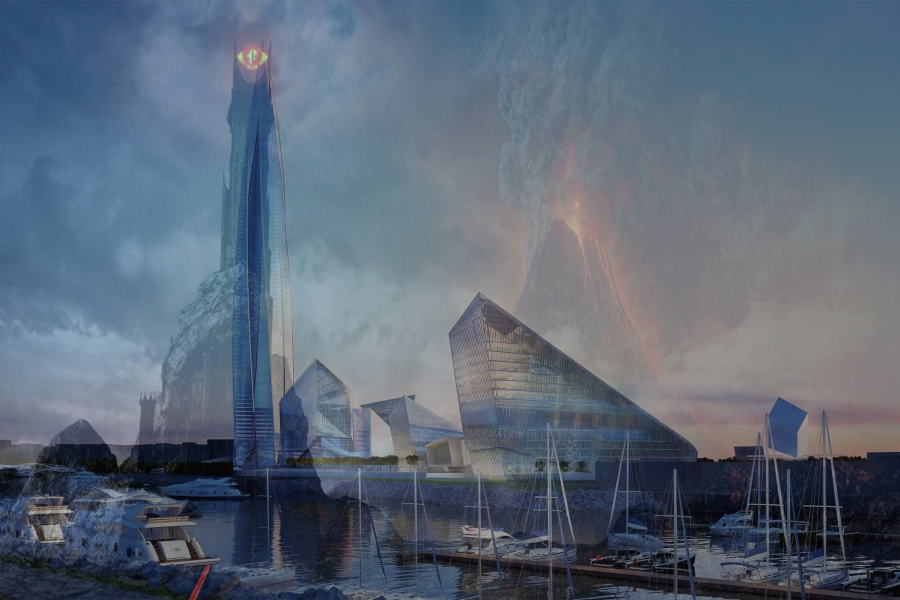

In [21]:
show(content1/2 + content2/2)

In [0]:
def transfer_param(content_image1, decorrelate=True, fft=True):
  transfer_input = param.image(*content_image1.shape[:2], decorrelate=decorrelate, fft=fft)[0]
  content_input1 = content_image1
  return tf.stack([transfer_input, content_input1])

# these constants help remember which image is at which batch dimension
TRANSFER_INDEX = 0
CONTENT_INDEX1 = 1
CONTENT_INDEX2 = 2

In [0]:
def mean_L1(a, b):
  return tf.reduce_mean(tf.abs(a-b))

@wrap_objective
def transfer_obj(layer_names, activation_loss_f=mean_L1, transform_f=None):
  def inner(T):
    # first we collect the (constant) activations of image we're computing the difference to

    # DREAM BIG
    image_activations1 = [T(layer_name)[1] for layer_name in layer_names]

    # we also set get the activations of the optimized image which will change during optimization
    optimization_activations = [T(layer)[0] for layer in layer_names]
    if transform_f is not None:
      optimization_activations = [transform_f(act) for act in optimization_activations]

    # we use the supplied loss function to compute the actual losses
    losses = [activation_loss_f(a, b) for a, b in zip(image_activations1, optimization_activations)]

    return tf.add_n(losses)

  return inner


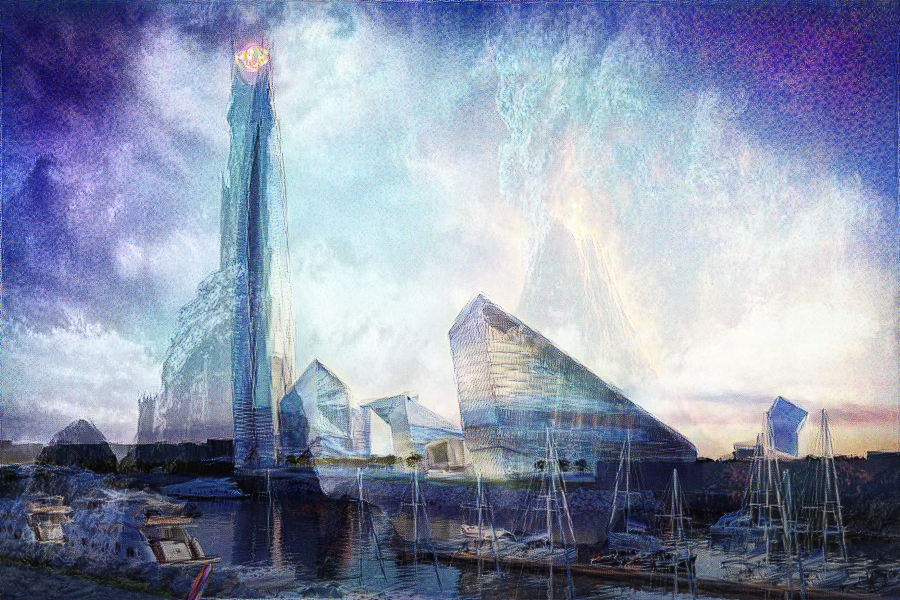
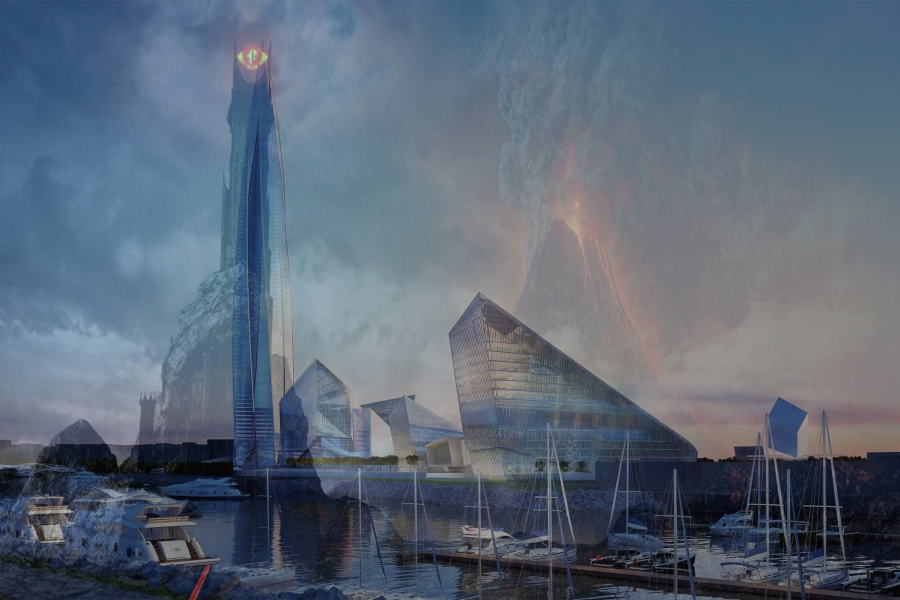

In [20]:
param_f = lambda: transfer_param(content1/2 + content2/2)

content_obj = transfer_obj(content_layers)
content_obj.description = "Content Loss"

# style_obj = 50 *  activation_difference(style_layers, transform_f=gram_matrix, difference_to=STYLE_INDEX)
# style_obj.description = "Style Loss"

objective = - content_obj * 10 # + sum([objectives.deepdream(l.name) for l in model.layers[-3:-1]]) * 0.5

vis = render.render_vis(model, objective, param_f=param_f, thresholds=[256], verbose=False)[-1]
show(vis)